In [1]:
import os
import json
import pandas as pd
from tqdm import tqdm

from datasets import (
    Dataset,
    DatasetDict,
    Features,
    Value,
    Sequence,
    load_from_disk,
    load_metric
)
from transformers import AutoTokenizer
from retrieval import Retriever

In [2]:
datasets = load_from_disk("../data/train_dataset")

documents = datasets['train']['context']
queries = datasets['train']['question']

In [3]:
data_path = "../data/"
context_path = "wikipedia_documents.json"

with open(os.path.join(data_path, context_path), "r", encoding="utf-8") as f:
            wiki = json.load(f)

total_contexts = list(dict.fromkeys([v["text"] for v in wiki.values()]))

In [9]:
topk = [1, 10, 20, 30, 50]
rerank_topk = [3, 30, 60, 90, 150]
retrievers = ['2s_rerank', 'BM25', 'Dense', 'hybridsearch', 'tfidf']
#['2s_rerank', 'BM25', 'Dense', 'hybridsearch', 'tfidf']
result = []

In [5]:
tokenizer = AutoTokenizer.from_pretrained("HANTAEK/klue-roberta-large-korquad-v1-qa-finetuned")

data_dict = {'question': queries[:int(len(queries)/5)]}
query_dataset = Dataset.from_dict(data_dict)
top_k = []
total = [[0.6063291139240506, 0.8734177215189873, 0.9012658227848102, 0.9227848101265823, 0.9354430379746835],[0.520253164556962, 0.8620253164556962, 0.9088607594936708, 0.9189873417721519, 0.9379746835443038],[0.48481012658227846, 0.7493670886075949, 0.7911392405063291, 0.8227848101265823, 0.8544303797468354], [0.6430379746835443, 0.9253164556962026, 0.9481012658227848, 0.9632911392405064, 0.9683544303797469]]
for r_name in tqdm(retrievers, desc="Retrievers Progress"):
    retriever = Retriever(
        tokenize_fn=tokenizer.tokenize,
        data_path=data_path,
        context_path=context_path,
        name=r_name
    )
    acc = []
    if r_name == '2s_rerank':
        top_k = rerank_topk
    else:
        top_k = topk
    for stopk in tqdm(top_k, desc=f"Top-k Progress for {r_name}", leave=False):
        cnt = 0
        contexts = retriever.retrieve(query_dataset, topk=stopk)
        
        # tqdm을 사용하여 queries 루프를 감싸서 진행 상태를 표시
        for idx in tqdm(range(int(len(queries)/5)), desc=f"Query Progress for {r_name}, Top-k={stopk}", leave=False):
            if documents[idx] in contexts[idx]:
                cnt += 1

        print(cnt / int(len(queries)/5))
        acc.append(cnt / int(len(queries)/5))
    total.append(acc)



# total = []
# for r_name in retrievers:
#     retriever = Retriever(
#         tokenize_fn=tokenizer.tokenize,
#         data_path=data_path,
#         context_path=context_path,
#         name=r_name
#     )
#     acc = []
#     for topk in top_k:
#         cnt = 0
#         contexts = retriever.retrieve(queries, topk=topk)
#         for idx in range(len(queries)):
#             if documents[idx] in contexts:
#                 cnt += 1
#         # for idx, query in enumerate(queries):
#         #     _ , contexts = retriever.retrieve(query, topk=topk)
#         #     if documents[idx] in contexts:
#         #         cnt += 1
#         print(cnt/len(queries))
#         acc.append(cnt/len(queries))
#     total.append(acc)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Retrievers Progress:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1133 > 512). Running this sequence through the model will result in indexing errors


[Sparse retrieval] :   0%|          | 0/790 [00:00<?, ?it/s]

0.24430379746835443


[Sparse retrieval] :   0%|          | 0/790 [00:00<?, ?it/s]

0.6455696202531646


[Sparse retrieval] :   0%|          | 0/790 [00:00<?, ?it/s]

0.730379746835443


[Sparse retrieval] :   0%|          | 0/790 [00:00<?, ?it/s]

0.7772151898734178


[Sparse retrieval] :   0%|          | 0/790 [00:00<?, ?it/s]



Retrievers Progress: 100%|██████████| 1/1 [02:21<00:00, 141.06s/it]

0.8367088607594937


In [6]:
print(total)

[[0.6063291139240506, 0.8734177215189873, 0.9012658227848102, 0.9227848101265823, 0.9354430379746835], [0.520253164556962, 0.8620253164556962, 0.9088607594936708, 0.9189873417721519, 0.9379746835443038], [0.48481012658227846, 0.7493670886075949, 0.7911392405063291, 0.8227848101265823, 0.8544303797468354], [0.6430379746835443, 0.9253164556962026, 0.9481012658227848, 0.9632911392405064, 0.9683544303797469], [0.24430379746835443, 0.6455696202531646, 0.730379746835443, 0.7772151898734178, 0.8367088607594937]]


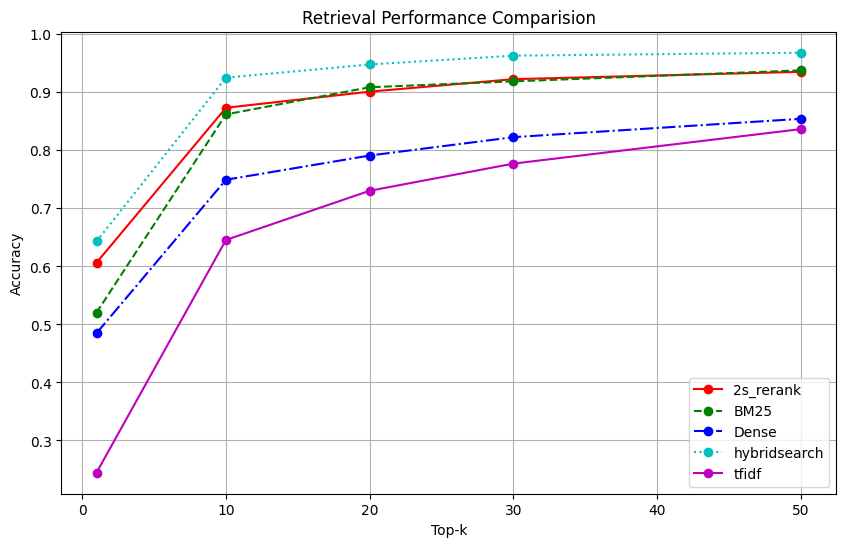

In [12]:
import matplotlib.pyplot as plt

colors = ['r', 'g', 'b', 'c', 'm']
linestyles = ['-', '--', '-.', ':', '-']

plt.figure(figsize=(10, 6))

for idx, r_name in enumerate(retrievers):
    acc = total[idx]
    plt.plot(top_k, acc, color=colors[idx % len(colors)], linestyle=linestyles[idx % len(linestyles)], marker='o', label=r_name)

plt.title('Retrieval Performance Comparision')
plt.xlabel('Top-k')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()